### 1. Import Library

In [14]:
# !pip install -r requirements.txt

In [15]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [16]:
# 난수 생성 고정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 2. Load Train Data & Test Data

In [17]:
# 데이터 경로 설정
DATA_PATH = Path("./data")

In [18]:
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")

In [19]:
# 필요 피처 선택
non_numeric_cols = ["faultNumber", "simulationRun", "sample"]
use_cols = train_data.columns.difference(non_numeric_cols)

X_train = train_data[use_cols]
X_test = test_data[use_cols]

#### 피처 선택 - 상위 10 상관계수가 높은 피처

In [20]:
# 주요 피처 도출 및 선택
# 피어슨 상관계수 계산
correlation_matrix = X_train.corr(method='pearson')

# 상관계수를 절대값으로 변환하고 상위 10개 출력
abs_corr = correlation_matrix.abs().unstack().sort_values(ascending=False)

# 대각선 요소(자기 자신과의 상관관계)를 제거
abs_corr = abs_corr[abs_corr < 1]

# 상위 10개 상관관계 도출
top_10_corr = abs_corr.head(10)

# 상위 10개 상관관계 피처 선택
selected_features = set()
for index in top_10_corr.index:
    selected_features.update(index)

selected_feature_list = list(selected_features)
print("Unique features from top 10 correlations:")
print(selected_feature_list)

X_train = train_data[selected_feature_list]
X_test = test_data[selected_feature_list]

Unique features from top 10 correlations:
['xmeas_13', 'xmv_8', 'xmv_3', 'xmeas_1', 'xmeas_15', 'xmeas_17', 'xmeas_12', 'xmv_11', 'xmeas_7', 'xmv_7']


In [21]:
print(len(X_train.columns))
print(len(X_test.columns))

10
10


In [22]:
# 필요한 라이브러리 임포트 
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from torch.utils.data import DataLoader, TensorDataset 
import torch

# 데이터 스케일러 인스턴스 생성(데이터 표준화)
## 어떤 스케일러를 적용해야하는가?
# scaler = MinMaxScaler()
scaler = RobustScaler() 
# 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
X_train_scaled = scaler.fit_transform(X_train) 
# 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
X_test_scaled = scaler.transform(X_test)  

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(X_train_scaled) 
X_test_tensor = torch.FloatTensor(X_test_scaled)  

# DataLoader 설정 
train_dataset = TensorDataset(X_train_tensor, X_train_tensor) # 입력과 타겟이 같음 
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, X_test_tensor) # 입력과 타겟이 같음 
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [23]:
print(len(train_dataset))
print(len(test_dataset))

250000
710400


In [24]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for data in test_loader:
    inputs = data[0]
    break

print(inputs.shape)

torch.Size([1, 10])


### 3. Autoencoder 구현

In [25]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더 구성
        ## 적절한 차원의 차수는?
        ## trial-1: 52 > 32 > 16
        ## trial-2: 52 > 32 > 16 > 8
        self.encoder = nn.Sequential(
            nn.Linear(10, 8), # 입력 차원 52에서 낮은 차수의 중간 차원 32로 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(8, 4), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
        )
        # 디코더 구성
        self.decoder = nn.Sequential(
            nn.Linear(4, 8), # 특징 차원 16에서 중간 차원 32으로 확장
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(8, 10), # 중간 차원 32에서 원본 차원인 55로 복원
            nn.Sigmoid() # 출력을 0과 1 사이로 조정
        )

    def forward(self, x):
        x = self.encoder(x) # 인코딩
        x = self.decoder(x) # 디코딩
        return x

### 4. Model Traning

In [26]:
model = Autoencoder()
criterion = nn.MSELoss() # MSE: Mean Squared Error 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer

for epoch in range(100):
    for data in train_loader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.7779356241226196
Epoch 1, Loss: 0.7801480293273926
Epoch 1, Loss: 0.7954100370407104
Epoch 1, Loss: 0.8230354189872742
Epoch 1, Loss: 0.7937901020050049
Epoch 1, Loss: 0.8289497494697571
Epoch 1, Loss: 0.8340966105461121
Epoch 1, Loss: 0.8059965372085571
Epoch 1, Loss: 0.7554345726966858
Epoch 1, Loss: 0.7694240212440491
Epoch 1, Loss: 0.8117561340332031
Epoch 1, Loss: 0.7955695986747742
Epoch 1, Loss: 0.8025520443916321
Epoch 1, Loss: 0.8006130456924438
Epoch 1, Loss: 0.8328855633735657
Epoch 1, Loss: 0.735761284828186
Epoch 1, Loss: 0.7429672479629517
Epoch 1, Loss: 0.7576521635055542
Epoch 1, Loss: 0.7722527384757996
Epoch 1, Loss: 0.8258182406425476
Epoch 1, Loss: 0.7738257646560669
Epoch 1, Loss: 0.773619532585144
Epoch 1, Loss: 0.7589205503463745
Epoch 1, Loss: 0.8285559415817261
Epoch 1, Loss: 0.777457058429718
Epoch 1, Loss: 0.8007626533508301
Epoch 1, Loss: 0.7719496488571167
Epoch 1, Loss: 0.7906032800674438
Epoch 1, Loss: 0.7508641481399536
Epoch 1, Loss: 0.

In [27]:
model_name = "exp1"
torch.save(model.state_dict(), f"./model_{model_name}.pt")

### 5. Model Inference

In [28]:
model.load_state_dict(torch.load("./model_exp1.pt"))

/tmp/ipykernel_654759/2685689877.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model_exp1.pt"))


<All keys matched successfully>

In [29]:
model.eval()

batch_size = len(train_dataset)
infer_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in infer_train_loader:
        inputs = data[0]
        outputs = model(inputs)

In [30]:
 # reconstruction error 계산 
train_reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1)  #MSE
print(train_reconstruction_errors)

df_train_reconstruction_errors = pd.DataFrame(train_reconstruction_errors.detach().numpy(), columns=["error"])
print(type(df_train_reconstruction_errors))
print(df_train_reconstruction_errors.shape)

max_error = df_train_reconstruction_errors["error"].max()
print(type(max_error))
print(max_error)

tensor([0.0139, 0.1802, 0.3053,  ..., 0.1217, 0.2939, 0.4039])
<class 'pandas.core.frame.DataFrame'>
(250000, 1)
<class 'float'>
3.006659984588623


In [31]:
df_train_reconstruction_errors.describe()

error
count  250000.000000
mean        0.328302
std         0.272971
min         0.000450
25%         0.127224
50%         0.256331
75%         0.452416
max         3.006660

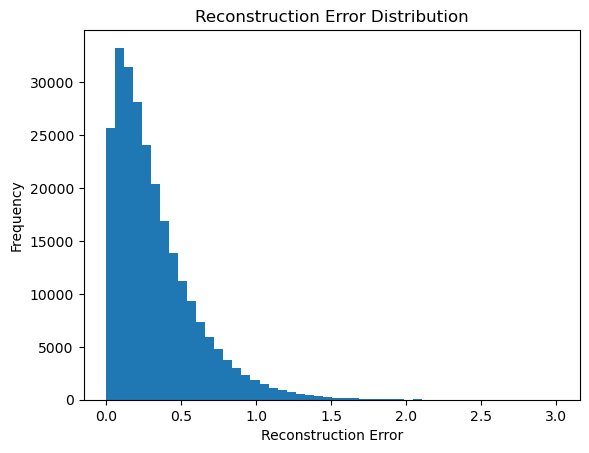

In [32]:
# reconstruction error 히스토그램 시각화 
plt.hist(train_reconstruction_errors.detach().numpy(), bins=50) 
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution')

plt.show()

In [33]:
model.eval()

batch_size = len(test_dataset)
infer_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in infer_test_loader:
        inputs = data[0]
        outputs = model(inputs)

In [34]:
# reconstruction error 계산 
test_reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1)  #MSE
print(test_reconstruction_errors)

df_test_reconstruction_errors = pd.DataFrame(test_reconstruction_errors.detach().numpy(), columns=["error"])
print(type(df_test_reconstruction_errors))
print(df_test_reconstruction_errors.shape)

tensor([1.2018e-01, 2.9342e-01, 3.5016e-01,  ..., 1.9339e+02, 1.9339e+02,
        1.9339e+02])
<class 'pandas.core.frame.DataFrame'>
(710400, 1)


In [35]:
df_test_reconstruction_errors.describe()

error
count  710400.000000
mean        6.974062
std        33.574615
min         0.000816
25%         0.149587
50%         0.311081
75%         0.603200
max       364.639954

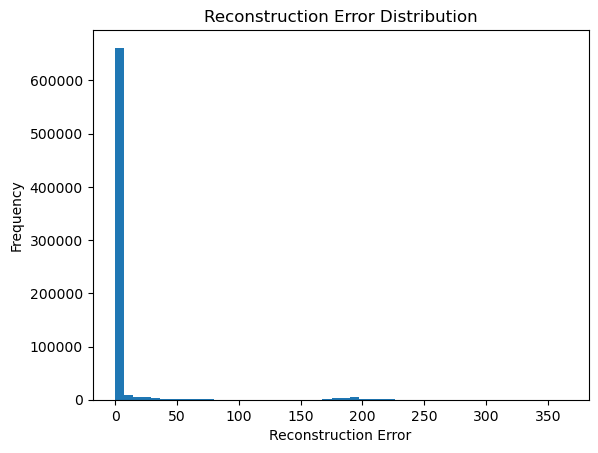

In [36]:
# reconstruction error 히스토그램 시각화 
plt.hist(test_reconstruction_errors.detach().numpy(), bins=50) 
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution')

plt.show()

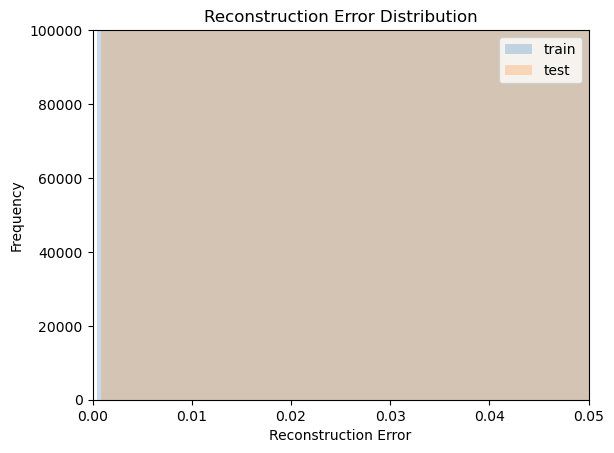

In [37]:
# reconstruction error 히스토그램 시각화
plt.hist(train_reconstruction_errors.detach().numpy(), alpha=0.25, label="train")
plt.hist(test_reconstruction_errors.detach().numpy(), alpha=0.25, label="test")
plt.xlim((0, 0.05))
plt.ylim((0, 100000))
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution')
plt.legend()

plt.show()

In [38]:
# threshold = max_error + max_error * 0.1

- [01] threshold = 0.016887
- [02] threshold = 0.016769 + (0.016769) * 0.1
- [03] threshold = 0.017843 + (0.017843) * 0.2

In [39]:
# threshold = np.mean(df_train_reconstruction_errors["error"]) + np.std(df_train_reconstruction_errors["error"])

In [40]:
threshold = np.mean(df_train_reconstruction_errors["error"]) + 3 * np.std(df_train_reconstruction_errors["error"])
print("threshold: ", threshold)

threshold:  1.147212266921997


- Initial
    - batchsize=64
    - epoch=20
- [04] threshold:  0.008588183671236038
- [05] threshold:  0.01129639009013772
- [06] threshold:  0.5062470883131027
    - batchsize=256
    - epoch=100
- [07] threshold:  0.7653539180755615
    - threshold = np.mean(df_train_reconstruction_errors["error"]) + 3 * np.std(df_train_reconstruction_errors["error"]): 3 곱하기 표준편차
- [08] 1.147212266921997
    - 상위 10개 피어슨 상관계수 피처 선택

In [41]:
df = df_test_reconstruction_errors.copy()

df["faultNumber"] = 0
df.loc[df["error"] > threshold, "faultNumber"] = 1

df_output = df.drop("error", axis=1)

In [42]:
df_output.value_counts()

faultNumber
0              625510
1               84890
Name: count, dtype: int64

In [43]:
from datetime import datetime

# CSV 파일로 저장
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"output_{current_time}.csv"
df_output.to_csv(filename)

In [44]:
print(threshold)

1.147212266921997
